<span style="color: red; font-size: 2em; font-weight: bold;">Example 3: Load - Solar Generator+Storage Unit</span>

Network Connections:
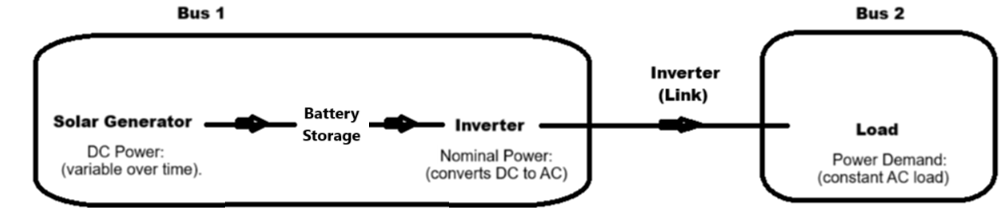

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.37s
INFO:pypsa.linopf:Solve linear problem using Glpk solver
INFO:pypsa.linopf:Optimization successful. Objective value: 0.00e+00


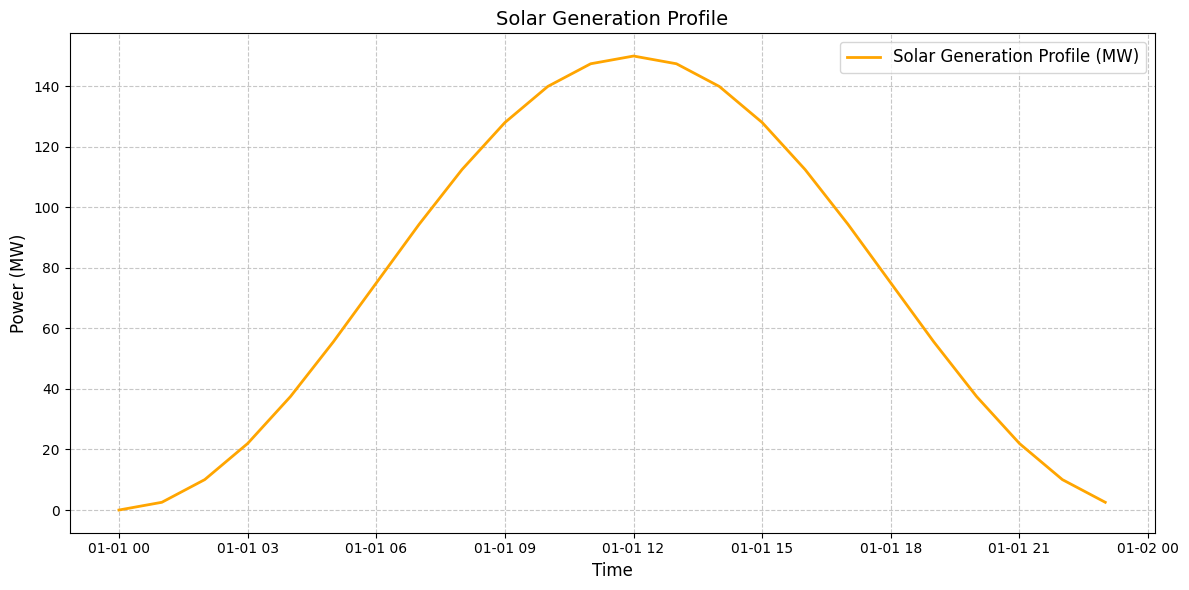

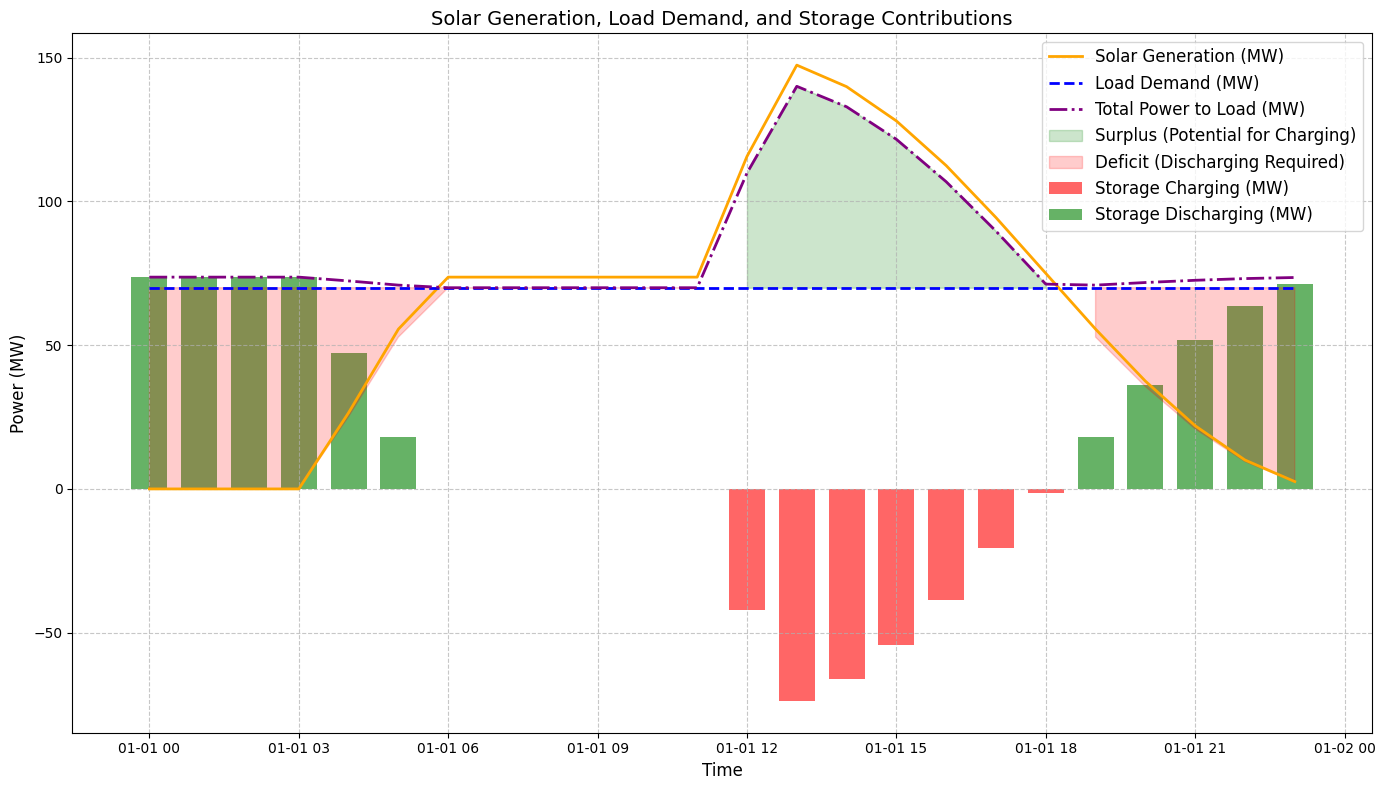

In [1]:
# Example 3 : Load - Solar Generator + Storage Unit
import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Create the network
network = pypsa.Network()

# 1 Add Buses
network.add("Bus", "bus1", carrier="DC")  # DC side (solar generator to inverter)
network.add("Bus", "bus2", carrier="AC")  # AC side (inverter to load)

# Define time steps for the simulation
hours = pd.date_range("2023-01-01 00:00", "2023-01-01 23:00", freq="H")
network.set_snapshots(hours)

# 2 Add Solar Generator

# Generate a realistic solar profile
solar_profile = pd.Series(0.5 * (1 + np.sin(2 * np.pi * (hours.hour - 6) / 24)), index=network.snapshots)
# Peaks around midday

p_nom_solar = 150  # Nominal power (MW)
network.add("Generator", 
            "Solar Generator", 
            bus="bus1", 
            p_nom=p_nom_solar, 
            p_max_pu=solar_profile, 
            carrier="solar")

# 3 Add Storage Unit
network.add("StorageUnit",
            "Battery Storage",
             bus="bus1",
             p_nom=200,
             max_hours=4,
             efficiency_store=0.9,
             efficiency_dispatch=0.9,
             state_of_charge_initial=400,
             carrier="battery")


# 4 Add Inverter (as a link)
inverter_efficiency = 0.95
network.add("Link", 
            "Inverter", 
            bus0="bus1", 
            bus1="bus2", 
            p_nom=p_nom_solar * 2, 
            efficiency = inverter_efficiency, 
            carrier="inverter")

# 5 Add Load

# Define constant load demand
p_load = 70  # Load demand in MW
load_demand = pd.Series(p_load, index=network.snapshots)

# Add Load
network.add("Load", 
            "Load", 
            bus="bus2", 
            p_set = load_demand)


# Solve the network using linear optimal power flow
network.lopf(network.snapshots)

# Extract results for storage and solar generation
storage_dispatch = network.storage_units_t.p["Battery Storage"]  # Charging (negative) and discharging (positive)
solar_generation = network.generators_t.p["Solar Generator"]  # Solar generation before inverter

# Total power delivered to the load (solar after inverter + battery discharge)
solar_to_load = solar_generation * inverter_efficiency  # Solar power after inverter losses
battery_to_load = storage_dispatch.clip(lower=0)  # Only discharging
total_power_to_load = solar_to_load + battery_to_load

# Separate charging and discharging for clarity
storage_charging = storage_dispatch.clip(upper=0)  # Negative values (charging)
storage_discharging = battery_to_load  # Positive values (discharging)

# Plot 1: Solar Generation Profile
plt.figure(figsize=(12, 6))
plt.plot(hours, solar_profile * p_nom_solar, label="Solar Generation Profile (MW)", color="orange", linewidth=2)
plt.title("Solar Generation Profile", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Power (MW)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


# Plot 2: Combined Plot
plt.figure(figsize=(14, 8))

# Plot Solar Generation and Load Demand
plt.plot(hours, solar_generation, label="Solar Generation (MW)", color="orange", linewidth=2)
plt.plot(hours, load_demand, label="Load Demand (MW)", color="blue", linestyle="--", linewidth=2)

# Overlay Storage Charging and Discharging
plt.bar(hours, storage_charging, label="Storage Charging (MW)", color="red", alpha=0.6, width=0.03)
plt.bar(hours, storage_discharging, label="Storage Discharging (MW)", color="green", alpha=0.6, width=0.03)

# Add the combined power to the load
plt.plot(hours, total_power_to_load, label="Total Power to Load (MW)", color="purple", linestyle="-.", linewidth=2)

# Add vertical shading for surplus and deficit regions
plt.fill_between(
    hours,
    solar_to_load,
    load_demand,
    where=(solar_to_load > load_demand),
    color="green",
    alpha=0.2,
    label="Surplus (Potential for Charging)"
)
plt.fill_between(
    hours,
    solar_to_load,
    load_demand,
    where=(solar_to_load < load_demand),
    color="red",
    alpha=0.2,
    label="Deficit (Discharging Required)"
)

# Labels, Legend, and Grid
plt.title("Solar Generation, Load Demand, and Storage Contributions", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Power (MW)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()

# Show the combined plot
plt.show()

<span style="color: red; font-size: 2em; font-weight: bold;">Step by step code</span>

# Step 1: Setting Up the Environment

## Install PyPSA

In [2]:
#!pip install pypsa

In [3]:
# Import pypsa 
import pypsa

## Additional Libraries
PyPSA may require other libraries for plotting and numerical operations:

In [4]:
# pip install numpy pandas matplotlib networkx

In [5]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

# Step 2: Creating Your Network:

## Creating the Network

In [6]:
# Create an empty network
network = pypsa.Network()

Network: Represents the electrical network.

## Add buses

In [7]:
# Add 2 buses
network.add("Bus", "bus1", carrier="DC")  # DC side (solar generator to inverter)
network.add("Bus", "bus2", carrier="AC")  # AC side (inverter to load)

network.buses

attribute,v_nom,type,x,y,carrier,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,sub_network
Bus,,,,,,,,,,,
bus1,1.0,,0.0,0.0,DC,,1.0,0.0,inf,PQ,
bus2,1.0,,0.0,0.0,AC,,1.0,0.0,inf,PQ,


Bus: A bus represents a point in the system where power is injected or consumed. It’s where all electrical components (load, generator) connect.

v_nom: This is the nominal voltage of the bus. For simplicity, we set it to 20 kV.

## Define time steps for the simulation

In [8]:
# Define time steps for the simulation
hours = pd.date_range("2023-01-01 00:00", "2023-01-01 23:00", freq="H")
network.set_snapshots(hours)
hours

DatetimeIndex(['2023-01-01 00:00:00', '2023-01-01 01:00:00',
               '2023-01-01 02:00:00', '2023-01-01 03:00:00',
               '2023-01-01 04:00:00', '2023-01-01 05:00:00',
               '2023-01-01 06:00:00', '2023-01-01 07:00:00',
               '2023-01-01 08:00:00', '2023-01-01 09:00:00',
               '2023-01-01 10:00:00', '2023-01-01 11:00:00',
               '2023-01-01 12:00:00', '2023-01-01 13:00:00',
               '2023-01-01 14:00:00', '2023-01-01 15:00:00',
               '2023-01-01 16:00:00', '2023-01-01 17:00:00',
               '2023-01-01 18:00:00', '2023-01-01 19:00:00',
               '2023-01-01 20:00:00', '2023-01-01 21:00:00',
               '2023-01-01 22:00:00', '2023-01-01 23:00:00'],
              dtype='datetime64[ns]', freq='H')

## Add a Generator: Solar Generator

In [9]:
# Generate a synthetic solar profile (simple sine curve for daily pattern). Peaks at noon
solar_profile = pd.Series(0.5 * (1 + np.sin(2 * np.pi * (hours.hour - 6) / 24)), index=network.snapshots)
solar_profile

snapshot
2023-01-01 00:00:00    0.000000
2023-01-01 01:00:00    0.017037
2023-01-01 02:00:00    0.066987
2023-01-01 03:00:00    0.146447
2023-01-01 04:00:00    0.250000
2023-01-01 05:00:00    0.370590
2023-01-01 06:00:00    0.500000
2023-01-01 07:00:00    0.629410
2023-01-01 08:00:00    0.750000
2023-01-01 09:00:00    0.853553
2023-01-01 10:00:00    0.933013
2023-01-01 11:00:00    0.982963
2023-01-01 12:00:00    1.000000
2023-01-01 13:00:00    0.982963
2023-01-01 14:00:00    0.933013
2023-01-01 15:00:00    0.853553
2023-01-01 16:00:00    0.750000
2023-01-01 17:00:00    0.629410
2023-01-01 18:00:00    0.500000
2023-01-01 19:00:00    0.370590
2023-01-01 20:00:00    0.250000
2023-01-01 21:00:00    0.146447
2023-01-01 22:00:00    0.066987
2023-01-01 23:00:00    0.017037
Freq: H, dtype: float64

In [10]:
# Add a generator to Bus 1 
p_nom_solar = 200  # Nominal power (MW)
network.add("Generator",
            "Solar Generator",
            bus = "bus1",
            p_nom = p_nom_solar, 
            p_max_pu = solar_profile,  
            marginal_cost = 50, 
            carrier="solar")

# solar_profile, %
#p_max_pu = solar_profile*p_nom

Generator: Represents a generator that supplies power to the grid.

    bus: This defines which bus the generator is connected to, in this case, Bus1. Connected to DC bus
    p_nom: Nominal power capacity (MW)
    p_max_pu=solar_profile,  # Time series for solar output

## Add Storage Unit

In [11]:
network.add("StorageUnit",
            "Battery Storage",
             bus="bus1",
             p_nom=200,
             max_hours=4,
             efficiency_store=0.9,
             efficiency_dispatch=0.9,
             state_of_charge_initial=400,
             carrier="battery")

## Add Inverter (as a link)

In [12]:
# Add Inverter (as a link) between Bus 1 (DC) and Bus 2 (AC)
inverter_efficiency = 0.95
network.add("Link", 
            "Inverter", 
            bus0="bus1", 
            bus1="bus2", 
            p_nom=p_nom_solar * 2, 
            efficiency = inverter_efficiency, 
            carrier="inverter")

            bus0="bus1"  # DC input
            bus1="bus2"  # AC output

## Add a Load
A load consumes power from the grid. Let’s add a load to Bus2 that will consume some power.

In [13]:
# Add a load to Bus 2
p_load = 70  # Constant load demand, (MW)
load_demand = pd.Series(p_load, index = network.snapshots)  # Constant across all snapshots
network.add("Load", 
            "Load",
            bus = "bus2", 
            p_set = load_demand)  

Load: Represents a power consumer.

bus: The bus where the load is connected. # Connected to AC bus

p_set: Constant load demand (MW)

# Step 3: Check results

In [14]:
# Print the network
print(network)

PyPSA Network
Components:
 - Bus: 2
 - Generator: 1
 - Link: 1
 - Load: 1
 - StorageUnit: 1
Snapshots: 24


# Step 4: Solving the Network
PyPSA includes tools for solving network power flows and optimization problems.

## Power Flow Calculation
After setting up the network, calculate the power flow:
We will now solve the network to find the power flow, voltages at each bus, and the power transmitted through the lines.

In [15]:
# Solve the network using linear optimal power flow
network.lopf(network.snapshots)

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.42s
INFO:pypsa.linopf:Solve linear problem using Glpk solver
INFO:pypsa.linopf:Optimization successful. Objective value: 7.17e+04


('ok', 'optimal')

## Extract results

You can inspect the power flows on lines and outputs of generators:

In [16]:
# Extract results for storage and solar generation
storage_dispatch = network.storage_units_t.p["Battery Storage"]  # Charging (negative) and discharging (positive)
solar_generation = network.generators_t.p["Solar Generator"]  # Solar generation before inverter


# Total power delivered to the load (solar after inverter + battery discharge)
solar_to_load = solar_generation * inverter_efficiency  # Solar power after inverter losses
battery_to_load = storage_dispatch.clip(lower=0)  # Only discharging
total_power_to_load = solar_to_load + battery_to_load

# Separate charging and discharging for clarity
storage_charging = storage_dispatch.clip(upper=0)  # Negative values (charging)
storage_discharging = battery_to_load  # Positive values (discharging)


# Power Visualization

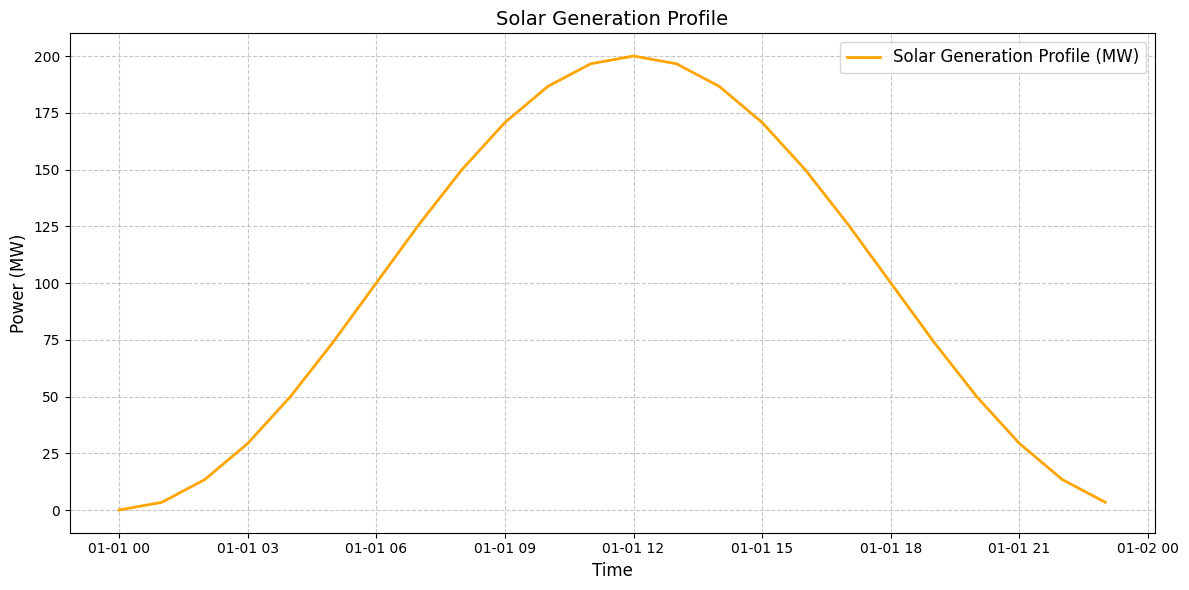

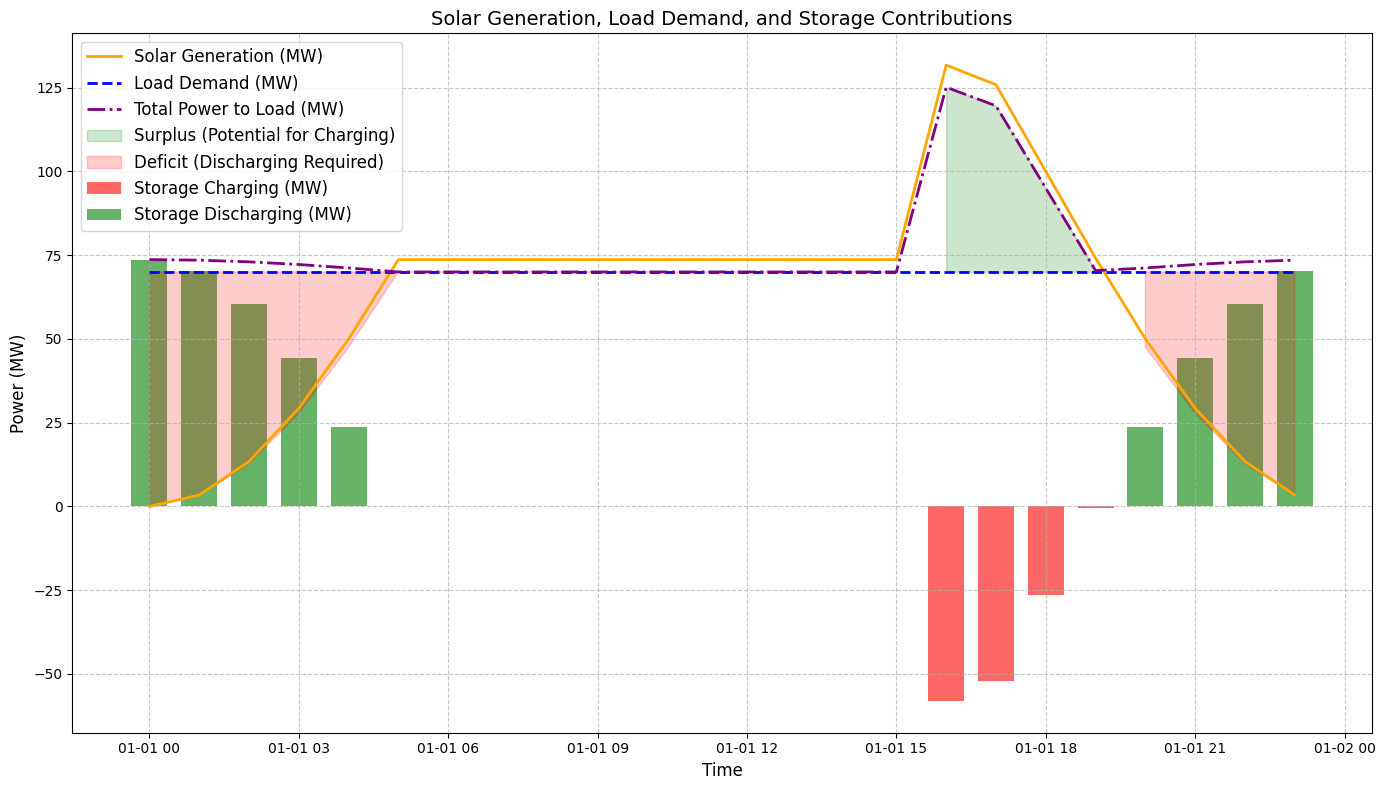

In [17]:

# Plot 1: Solar Generation Profile
plt.figure(figsize=(12, 6))
plt.plot(hours, solar_profile * p_nom_solar, label="Solar Generation Profile (MW)", color="orange", linewidth=2)
plt.title("Solar Generation Profile", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Power (MW)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


# Plot 2: Combined Plot
plt.figure(figsize=(14, 8))

# Plot Solar Generation and Load Demand
plt.plot(hours, solar_generation, label="Solar Generation (MW)", color="orange", linewidth=2)
plt.plot(hours, load_demand, label="Load Demand (MW)", color="blue", linestyle="--", linewidth=2)

# Overlay Storage Charging and Discharging
plt.bar(hours, storage_charging, label="Storage Charging (MW)", color="red", alpha=0.6, width=0.03)
plt.bar(hours, storage_discharging, label="Storage Discharging (MW)", color="green", alpha=0.6, width=0.03)

# Add the combined power to the load
plt.plot(hours, total_power_to_load, label="Total Power to Load (MW)", color="purple", linestyle="-.", linewidth=2)

# Add vertical shading for surplus and deficit regions
plt.fill_between(
    hours,
    solar_to_load,
    load_demand,
    where=(solar_to_load > load_demand),
    color="green",
    alpha=0.2,
    label="Surplus (Potential for Charging)"
)
plt.fill_between(
    hours,
    solar_to_load,
    load_demand,
    where=(solar_to_load < load_demand),
    color="red",
    alpha=0.2,
    label="Deficit (Discharging Required)"
)

# Labels, Legend, and Grid
plt.title("Solar Generation, Load Demand, and Storage Contributions", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Power (MW)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()

# Show the combined plot
plt.show()